# Boundary Equilibrium GAN

Wasserstein distance로 부터 얻은 loss 이용하여 빠르고 안정적인 학습을 가능케하는 auto-encoder 기반의 GAN 을 제시  

1. 단순하지만 강건한 구조와 빠르고 안정적인 학습이 가능한 GAN
2. 생성자와 판별자간의 균형을 잡아주는 equilibrium concept
3. image diversity 와 visual quality 사이의 trade-off를 조정하는 방법 제시
4. 수렴의 approximate measure

## Wasserstein distance lower bound for auto-encoder

기존의 GAN 처럼 data distribution 을 찾는 것이 아니라 loss dstribution을 이용한다.  

Wasserstein distance  
$$ W_1(\mu_1,\mu_2) = \inf_{γ\in\prod(\mu_1,\mu_2)} \mathbb{E}_{(x,y) \sim γ}[ |x-y| ] $$
에서 Jensen's inequalitiy에 의해서 
$$ \inf \mathbb{E} [|x-y|] \ge |\inf \mathbb{E} [x-y]| = |m_1 - m_2|$$
로 lower bound를 잡을 수 있다.  

여기서 $\mu_1$은 $L(x)$의 분포, $mu_2$는 $L(G(z))$의 분포라 하면 $|m_1 - m_2|$ 를 최대화 하는 경우는 아래의 두가지다. 

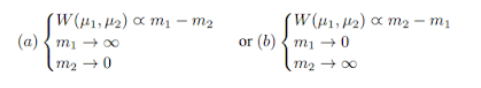

논문에서는 $m_1$이 0으로 가는 것이 실제 이미지의 대해서 loss가 0으로 가는것과 자연스럽게 이어져서 (b)를 선택했다.

BEGAN의 목적함수는  

$ 𝓛_D = 𝓛(x;\theta_D) - 𝓛(G(z;\theta_G);\theta_D) $  
$ 𝓛_G = 𝓛(G(z;\theta_G);\theta_D) $ 으로 하는데
WGAN 의 목적함수와 유사하지만 두가지 차이점이 있다.
1. 샘플들간의 분포를 매치하는 것이 아닌 Loss distribution 간의 분포를 매치시키는 것
2. WGAN 처럼 립시츠 함수여야 한다는 조건이 필요 없어짐 

## Equilibrlium

생성자와 판별자간의 학습 균형을 맞추기 위해서 새로운 hyper-parameter $\gamma \in [0,1]$를 다음과 같이 한다.  

$$γ = \frac{𝔼[𝓛(G(z))]}{𝔼[𝓛(x)]}$$  
예를 들어 $\gamma$를 작게 하면 다양한 이미지를 생성하는 것보다 실제이미지를 auto-encoding 하는 것에 더 초점을 두어 학습을 하게 된다.
즉 판별자와 생성자간의 학습 조절을 할 수 있다.

## Objective

$ 𝓛_D = 𝓛(x) - k_t ⋅ 𝓛(G(z)) $  
$ 𝓛_G = 𝓛(G(z)) $  
$ k_{t+1} = k_t + λ_k(\gamma 𝓛(x)- 𝓛(G(z))) $  

$k_t$를 이용하여 학습중 $𝓛(G(z))$을 얼마나 강조할지 조정한다. 
학습 후 금방 생성자는 재생성하기 쉬운 데이터를 생성하는 경향을 보인다고 한다.

## Convergence measure

GAN 의 수렴을 판단하는 것은 일반적으로 어려운 문제였다. 논문에서는 수렴정도를 측정할 수 있는 하나의 지표, Global Convergence Measurement를 제안

$$ 𝓜_{global} = 𝓛(x) +|\gamma𝓛(x)-𝓛(G(z))| $$

이 값을 통해 모델이 수렴에 도달했는지 mode collapse가 발생했는지 판단 할 수 있다.

## Experiments

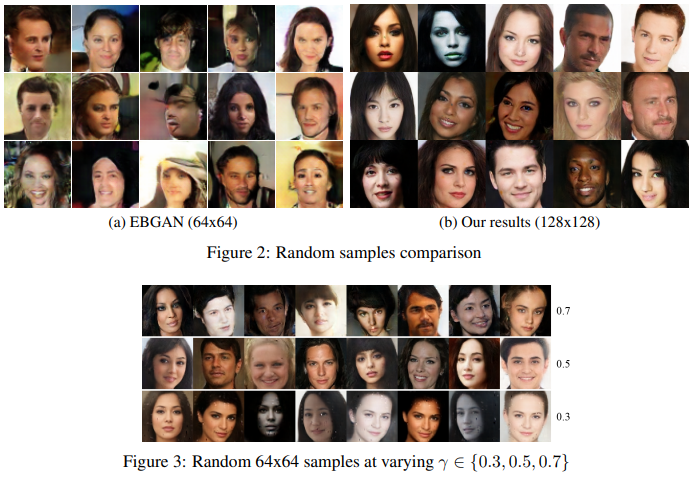

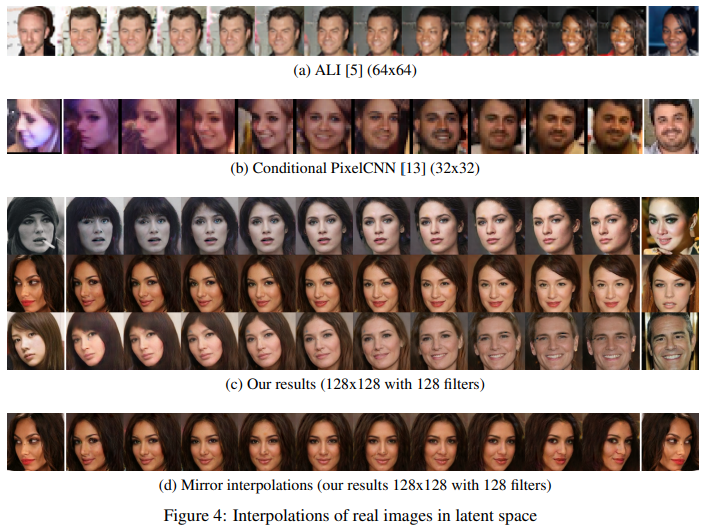

latent space를 잘 학습한 모습

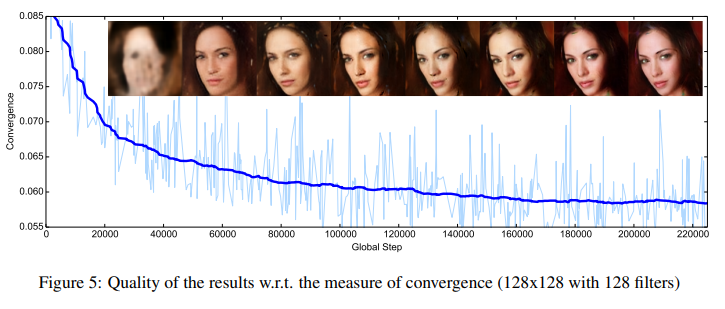

위에서 정의한 수렴 메저가 실제로 모델의 수렴과 잘 대응됨을 볼 수 있음

# 코드 실습

In [1]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import matplotlib.pyplot as plt
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 변수 정의

workers = 16
batch_size = 128
image_size = 32

nc = 3
nz = 100
ngf = 64
ndf = 64
nf = 64
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

ngpu = 1

device = torch.device('cuda' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Datasets')
os.listdir('./CelebA/')

['img_align_celeba']

In [ ]:
# 데이터 로드
os.chdir('/content/drive/MyDrive/Colab Notebooks/Datasets')
folder_path = './CelebA'
train_dataset = datasets.ImageFolder(root=folder_path,
                                     transform=transforms.Compose([transforms.Resize(image_size),
                                                                   transforms.CenterCrop(image_size),
                                                                   transforms.ToTensor(),
                                                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# https://github.com/1Konny/BEGAN-pytorch/blob/master/solver.py
# BEGAN

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(nz, nf*8*8)
        self.main = nn.Sequential(
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.ELU(True),
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.ELU(True),
            nn.ConvTranspose2d(nf,2*nf,4,2,1),
            nn.Conv2d(2*nf, nf, 3, 1, 1),
            nn.ELU(True),
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.ELU(True),
            nn.ConvTranspose2d(nf,2*nf,4,2,1),
            nn.Conv2d(2*nf, nf, 3, 1, 1),
            nn.ELU(True),
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.ELU(True),
            nn.Conv2d(nf, 3, 3, 1, 1),
            nn.Tanh()
        )
        
    def forward(self, input):
      h0 = self.fc(input)
      h0 = h0.view(h0.size(0),nf,8,8)
      out = self.main(h0)
      return out

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            #32x32
            nn.Conv2d(3, nf, 3, 1, 1),
            nn.ELU(True),
            #32x32
            nn.Conv2d(nf, nf, 3, 1, 1),
            nn.ELU(True),
            #32x32
            nn.Conv2d(nf, nf*2, 4, 2, 1),
            nn.ELU(True),
            #16x16
            nn.Conv2d(nf*2, nf*2, 3, 1, 1),
            nn.ELU(True),
            #16x16
            nn.Conv2d(nf*2, nf*3, 4, 2, 1),
            nn.ELU(True),
            #8x8
            nn.Conv2d(nf*3, nf*3, 3, 1, 1),
            nn.ELU(True),
            nn.Conv2d(nf*3, nf*3, 3, 1, 1),
            nn.ELU(True)
          )
        self.fc = nn.Linear(8*8*nf*3, nz)

    def forward(self, input):
      out = self.main(input)
      out = out.view(out.size(0),-1)
      out = self.fc(out)
      return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encode = Encoder()
        self.decode = Decoder()

    def forward(self, image):
        out = self.encode(image)
        out = self.decode(out)
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decode = Decoder()

    def forward(self, h):
        out = self.decode(h)
        return out

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

G.apply(weights_init)
D.apply(weights_init)

D_optim = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
G_optim = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
# https://github.com/1Konny/EBGAN-pytorch/blob/master/solver.py

img_list = []
G_losses = []
D_losses = []

pbar = tqdm_nb()
piter = 0

gamma = 0.85
lambda_k = 0.001
num_epochs = 20
print("Starting Training Loop...")

for epoch in range(num_epochs):

    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    Kt = 0.0
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        # D 학습
        if i % 1 == 0:
          # Discriminator Training
          x_real = data[0].to(device)
          D_real = D(x_real)
          D_loss_real = F.l1_loss(D_real, x_real)

          b_size = x_real.size(0)
          z = torch.randn(b_size, nz, device=device)
          x_fake = G(z)
          D_fake = D(x_fake)
          D_loss_fake = F.l1_loss(D_fake, x_fake)

          D_loss = D_loss_real - Kt*D_loss_fake

          D_optim.zero_grad()
          D_loss.backward()
          D_optim.step()
          
        # G 학습
        if i % 1 == 0:
          b_size = x_real.size(0)
          z = torch.randn(b_size, nz, device=device)
          x_fake = G(z)
          D_fake = D(x_fake)

          G_loss = F.l1_loss(x_fake, D_fake)

          G_optim.zero_grad()
          G_loss.backward()
          G_optim.step()
        # Kt update
        balance = (gamma*D_loss_real - D_loss_fake).item()
        Kt = max(min(Kt + lambda_k*balance, 1.0), 0.0)
        desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                % (epoch+1, num_epochs, i, epoch_steps, D_loss.item(), G_loss.item())
        pbar.set_description(desc)

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        # fake image 생성
        #if (piter - 1) % 5 == 0:
        #    with torch.no_grad():
        #        fake = netG(fixed_noise).detach().cpu()
        #   img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
        print(desc)

pbar.refresh()

In [ ]:
torch.save({
    'BEGAN_G' : G.state_dict(),
    'BEGAN_D' : D.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/model_save/BEGAN_CelebA_15epochs')

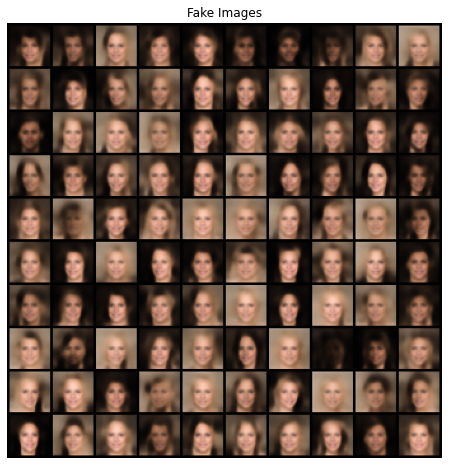

In [ ]:
# Generated Images

#for epoch in range(1,41,2):
fixed_noise = torch.randn(100,100,device=device)
fake = G(fixed_noise).detach().cpu()

plt.figure(figsize=(8, 8))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True, nrow=10),(1,2,0)))
plt.show()

In [ ]:
# load params

state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/EBGAN-PT_CelebA_200epochs')
netG.load_state_dict(state_dict['EBGAN-PT_G'])
netD.load_state_dict(state_dict['EBGAN-PT_D'])


<All keys matched successfully>

In [ ]:
X = []
for _ in range(10):
  a = torch.randn(nz,1,1)
  b = torch.randn(nz,1,1)
  X.append(np.linspace(a,b,10))
X = torch.Tensor(np.array(X).reshape(100,100,1,1)).to(device)
images = netG(X).detach().cpu()
plt.figure(figsize=(13,13))
plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True, nrow=10),(1,2,0)))
plt.show()